# Introduction - Hospital Readmissions Modeling and Interpretation

In this notebook, we iterate through a number of classification model in order to find the model that best predicts hospital readmissions. We use the evaluation metrics of precision, recall, accuracy and F1 score to measure the performance of our models, with a particular emphasis on the model with the best recall. We then explore which features are most important in the final model to determining readmissions.

![hospital_beds](images/hosp_beds.jpg)

# Modeling

In [1]:
#import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("viridis")

In [2]:
# load clean dataset and inspect

data = pd.read_csv('data/diabetes_data_clean.csv', index_col=0)

data.head()

,encounter_id,patient_nbr,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,diag_3_respiratory,max_glu_serum__300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult__8,A1Cresult_None,A1Cresult_Norm,insulin_No,insulin_Steady,insulin_Up
1,149190,55629189,12,3,59,0,18,0,0,0,...,0,0,1,0,0,1,0,0,0,1
2,64410,86047875,26,2,11,5,13,2,0,1,...,0,0,1,0,0,1,0,1,0,0
3,500364,82442376,38,2,44,1,16,0,0,0,...,0,0,1,0,0,1,0,0,0,1
4,16680,42519267,43,1,51,0,8,0,0,0,...,0,0,1,0,0,1,0,0,1,0
5,35754,82637451,53,3,31,6,16,0,0,0,...,0,0,1,0,0,1,0,0,1,0


In [3]:
# set variables for model
y = data['readmitted']
X = data.drop(columns=['encounter_id', 'patient_nbr', 'readmitted'])

#set names to be used in classification report and confusion matrix
class_names = np.array(['not readmitted', 'readmitted'])

In [4]:
# perform train test split on data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

## Create Functions for Modeling and Visualizations

In [5]:
# creates a dictionary of evaluaton metric scores for the model running
def get_scores(y_test, y_hat_test):
    scores_dict = {'precision':round(precision_score(y_test, y_hat_test),2),
           'recall': round(recall_score(y_test, y_hat_test),2),
           'accuracy': round(accuracy_score(y_test, y_hat_test),2),
           'f1': round(f1_score(y_test, y_hat_test),2)}
    return scores_dict

In [6]:
# fits the model and outputs evaluation metrics

def run_model(model):
    
    # fit model
    model.fit(X_train, y_train)
    
    # make predictions
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    
    # print classification report
    print(classification_report(y_test, y_hat_test, target_names=class_names))
    
    # plot confusion matrix
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title('Confusion Matrix')
    disp = plot_confusion_matrix(model, X_test, y_test, ax = ax,
                                 display_labels = class_names,
                                 normalize='true')
    plt.grid(False)
    
    return get_scores(y_test, y_hat_test)

In [7]:
# plot the ROC curve of the model
def plot_roc(model):
    y_score = model.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)

    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [8]:
# plot the top 10 important features of the model
def plot_top_10_features(model, model_name):
    feature_names = X_train.columns
    feature_imports = model.feature_importances_
    most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], 
                                     columns=["Feature", "Importance"]).nlargest(10, "Importance")
    most_imp_features.sort_values(by="Importance", inplace=True)

    plt.figure(figsize=(12,5))
    plt.barh(range(len(most_imp_features)), most_imp_features.Importance, 
             align='center', alpha=0.8, color='teal')
    plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=12)
    plt.xlabel('Importance')
    plt.title(f'Most Important Features - {model_name}', fontsize=12)
    plt.show()

## Logistic Regression Model

We will start with a simple logistic regression model using scikit learn. For the baseline model, we will set the C value to 1e12, and use the defaults for all other parameters.

### Baseline Logistic Regression

In [9]:
# import necessary libraries

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score 
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [10]:
# instantiate LogisticRegression()

logreg = LogisticRegression(C=1e12, random_state=22)

C:\Users\saman\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                precision    recall  f1-score   support

not readmitted       0.61      0.78      0.68     12972
    readmitted       0.64      0.44      0.52     11541

      accuracy                           0.62     24513
     macro avg       0.62      0.61      0.60     24513
  weighted avg       0.62      0.62      0.60     24513



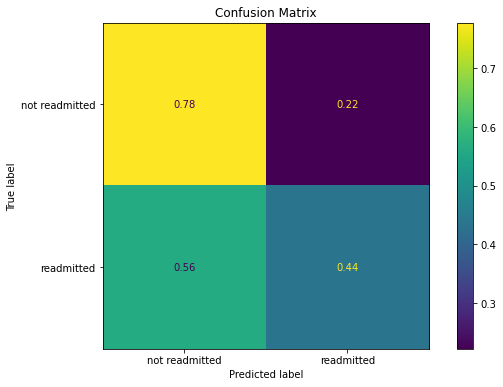

In [11]:
# Use run_model function to fit the model, make predictions, 
# print classification report, plot confusion matrix,
# and store evaluation metrics

log_scores = run_model(logreg)

In [12]:
log_scores

{'precision': 0.64, 'recall': 0.44, 'accuracy': 0.62, 'f1': 0.52}

### Logistic Regression - Balanced Class Weight

Based on the above confusion matrix, it appears more of the true readmissions are being classified as not readmissions. We suspect this has something to do with unequal class weights. Let's see if passing a class_weight parameter of 'balanced' helps our results.

In [13]:
# confirm class weights are unequal
data.readmitted.value_counts()

0    52337
1    45715
Name: readmitted, dtype: int64

In [14]:
logreg_balance = LogisticRegression(C= 1e12,
                                    class_weight='balanced', random_state=7)

C:\Users\saman\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                precision    recall  f1-score   support

not readmitted       0.63      0.70      0.66     12972
    readmitted       0.61      0.54      0.57     11541

      accuracy                           0.62     24513
     macro avg       0.62      0.62      0.62     24513
  weighted avg       0.62      0.62      0.62     24513



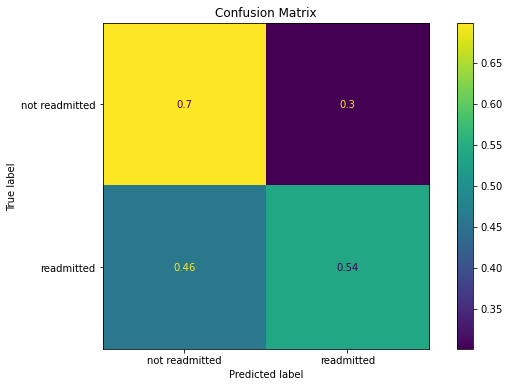

In [15]:
log_balance_scores = run_model(logreg_balance)

In [16]:
log_balance_scores

{'precision': 0.61, 'recall': 0.54, 'accuracy': 0.62, 'f1': 0.57}

Our recall, and f1 score improved; since our recall score is most important to us, we are going to store the scores from this model as our logistic regression scores.

In [17]:
log_scores = log_balance_scores

Let's also plot our ROC function to get a sense for our true positive rate vs. false positive rate.

C:\Users\saman\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.6608017219868736


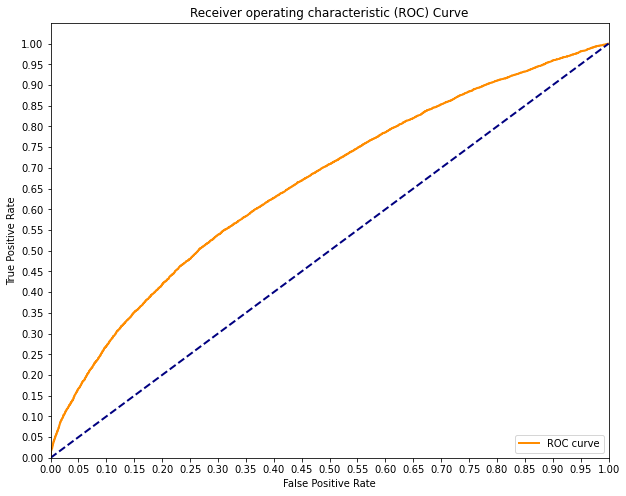

In [18]:
from sklearn.metrics import roc_curve, auc

plot_roc(logreg_balance)

The area under the curve of this model is ~.68, so there is defintely room to improve this model, as the closer the AUC gets to 1 the better. This means there is a 68% chance the model can distinguish between a readmit and a non-readmit.

Let's try using a different classification model and see if we can improve our results.

## Decision Trees

Next, we are going to see if we can obtain better test results using decision trees. Decision trees classify categorical data by partitioning the data into sets of similar datapoints.

We had attempted using a K-Nearest Neighbors classifier, but given our dataset has nearly 100k rows, using this classifier was not practical from a runtime or memory standpoint. 

### Baseline Decision Tree

                precision    recall  f1-score   support

not readmitted       0.58      0.58      0.58     12972
    readmitted       0.52      0.52      0.52     11541

      accuracy                           0.55     24513
     macro avg       0.55      0.55      0.55     24513
  weighted avg       0.55      0.55      0.55     24513



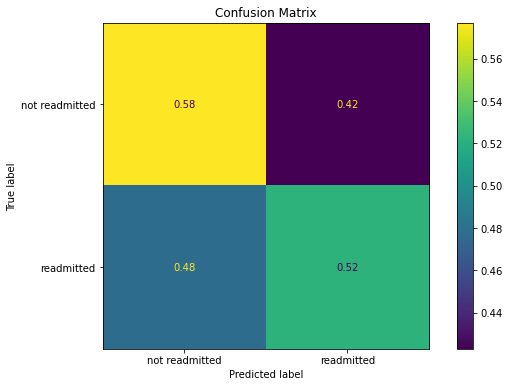

In [19]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree_baseline = DecisionTreeClassifier(random_state=3)
tree_scores = run_model(tree_baseline)

In [20]:
tree_scores

{'precision': 0.52, 'recall': 0.52, 'accuracy': 0.55, 'f1': 0.52}

Our scores did not improve from our logistic regression model, however, we should be able to improve these results by tuning our model.

### Improved Decision Tree Using GridSearchCV

Next, we are going to use GridSearchCV to figure out the optimal parameters for the decision tree model. See below for a quick description of what each of these parameters mean:

* criterion: methodology used to calculate information gain
* max_depth: restrict the depth of the tree to be more generalized
* min_samples_split: the minimum number of samples required to split an internal node
* min_samples_leaf: the minimum number of samples required to be at a leaf node--in this case, min_samples_leaf x n_samples is the minimum number of samples at each split.

In [21]:
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3,5,10],
    'min_samples_split': [5,10,20],
    'min_samples_leaf': [0.1, 0.3, 0.5]
}

grid_tree = GridSearchCV(clf, param_grid, cv=3)
grid_tree.fit(X_train, y_train)

grid_tree.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 0.1,
 'min_samples_split': 5}

                precision    recall  f1-score   support

not readmitted       0.60      0.75      0.67     12972
    readmitted       0.62      0.45      0.52     11541

      accuracy                           0.61     24513
     macro avg       0.61      0.60      0.59     24513
  weighted avg       0.61      0.61      0.60     24513



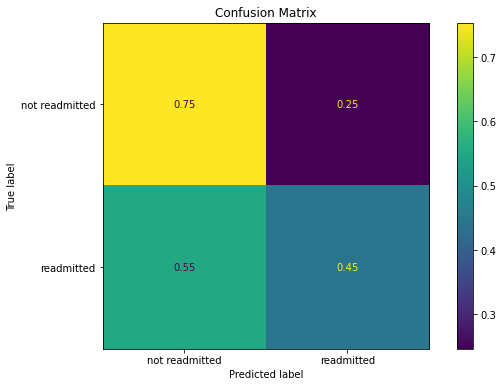

In [22]:
# apply the best parameters from grid search to the new decision tree

new_tree = DecisionTreeClassifier(criterion = grid_tree.best_params_['criterion'], 
                                   max_depth = grid_tree.best_params_['max_depth'], 
                                   min_samples_split = grid_tree.best_params_['min_samples_split'],
                                   min_samples_leaf = grid_tree.best_params_['min_samples_leaf'],
                                 random_state=5)
new_tree_scores = run_model(new_tree)

In [23]:
new_tree_scores

{'precision': 0.62, 'recall': 0.45, 'accuracy': 0.61, 'f1': 0.52}

Although our precision and accuracy increased, our recall actually decreased, which is the metric we are most interested in improving. Even though we are more concerned about recall, it is likely to be more useful to have a more generalized tree, so we are going to proceed with this version of the model.

In [24]:
tree_scores = new_tree_scores

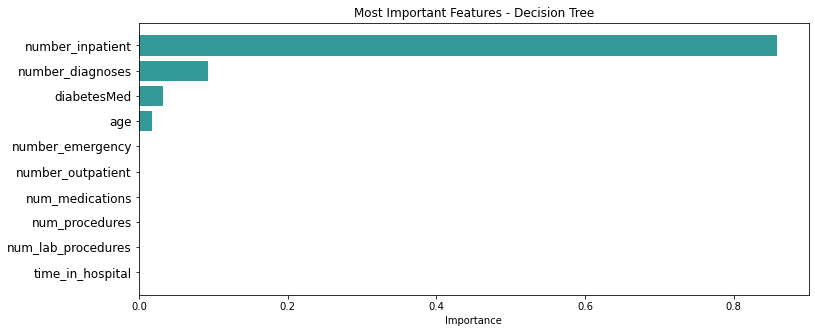

In [25]:
plot_top_10_features(new_tree, 'Decision Tree')

In this model, our most important features are the number of inpatient visits, diagnoses, whether or not someone is on diabetes medication and age. Let's also look at the structure of our actual tree.

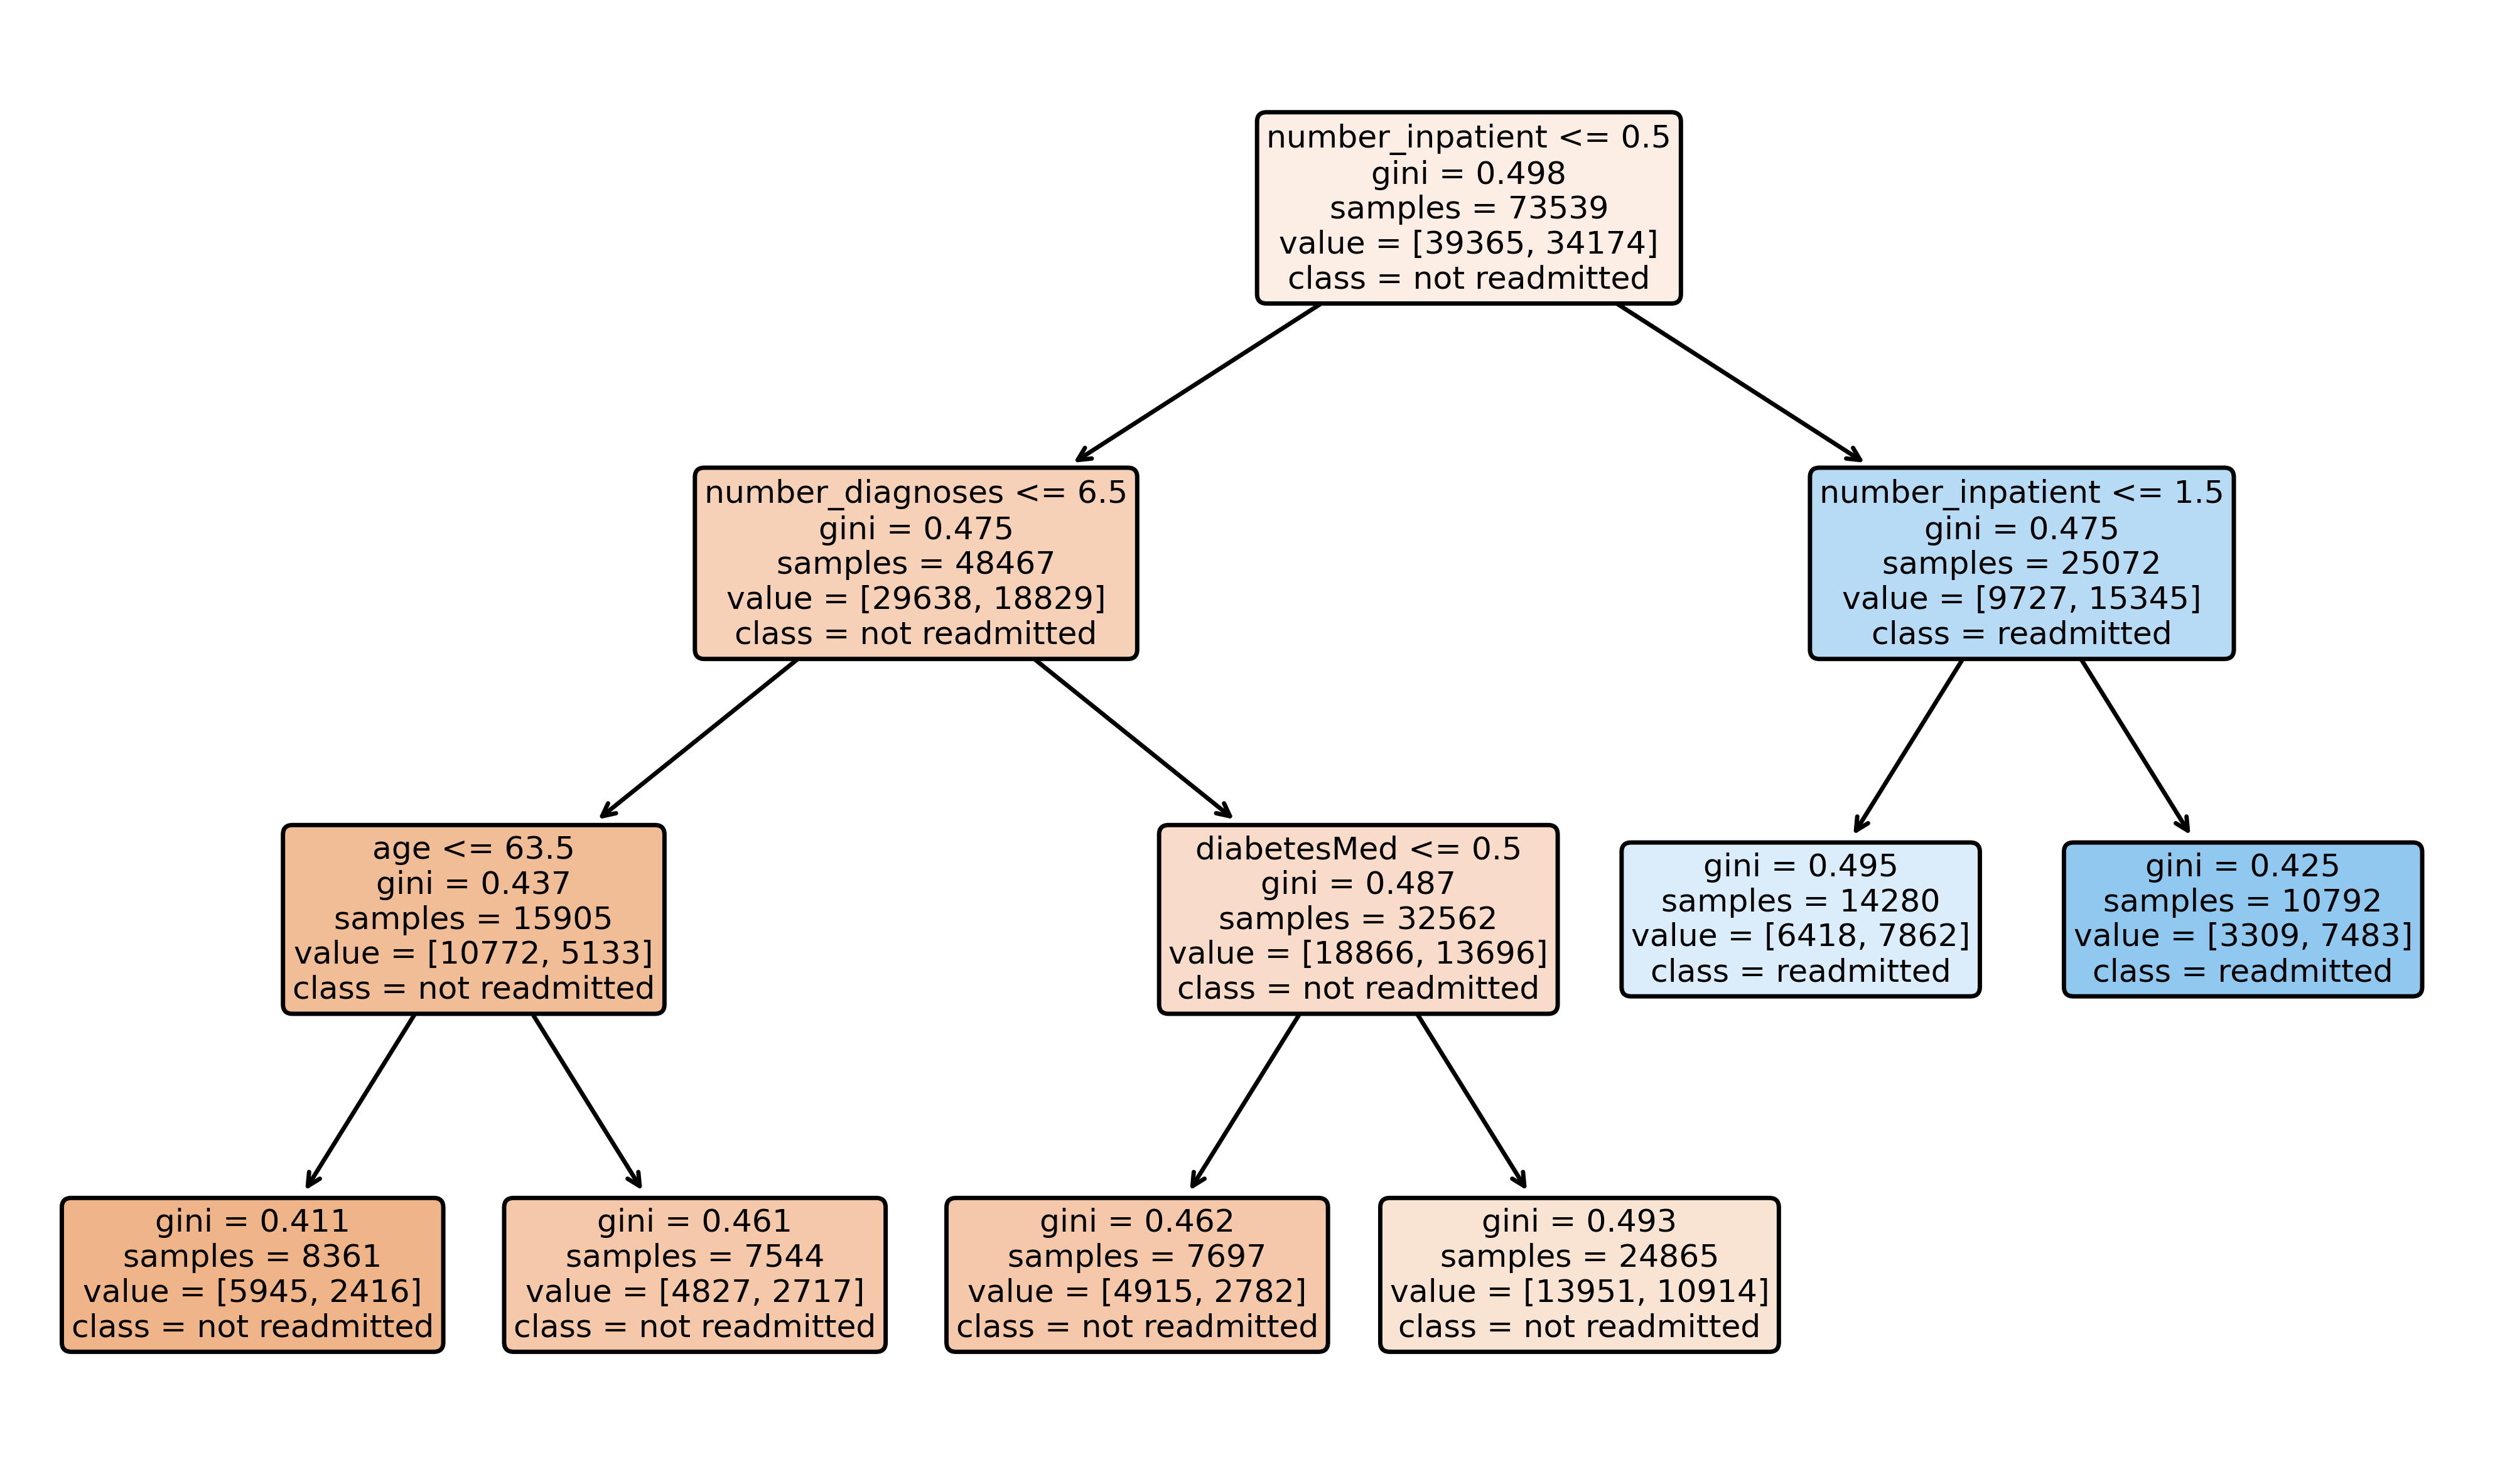

In [26]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (10,6), dpi=500)
plot_tree(new_tree,
          feature_names = X.columns, 
          class_names = np.array(['not readmitted', 'readmitted']),
          filled = True, rounded=True)
plt.show()

Our results did not improve significantly by using a decision tree with optimal parameters over logistic regression. Next, we are going to test out some ensemble methods to try to improve the quality of these predictions.

## Tree Ensemble Methods

In [27]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

### Bagged Tree

The first model we are going to run is a bagged tree model, which makes use of bagging and a number of decision trees. Bagging is also known as bootstrap aggregation, where two-thirds of the training data is used to build each tree. We are going to use the same parameters as our grid search tree above and 50 estimators.

                precision    recall  f1-score   support

not readmitted       0.60      0.75      0.67     12972
    readmitted       0.62      0.45      0.52     11541

      accuracy                           0.61     24513
     macro avg       0.61      0.60      0.59     24513
  weighted avg       0.61      0.61      0.60     24513



{'precision': 0.62, 'recall': 0.45, 'accuracy': 0.61, 'f1': 0.52}

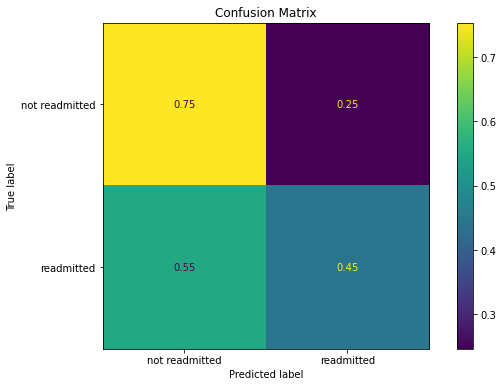

In [28]:
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion=grid_tree.best_params_['criterion'], 
                                                       max_depth=grid_tree.best_params_['max_depth'], 
                                                       min_samples_split=grid_tree.best_params_['min_samples_split'],
                                                       min_samples_leaf=grid_tree.best_params_['min_samples_leaf']
                                                      ), n_estimators=50, random_state=6)
run_model(bagged_tree)

We achieved the same performance metric results as we did with our GridSearch decision tree. Let's see if using random forests will get us better results.

### Random Forests

Random forests are an ensemble method that create a "forest" of decision trees, which often lead to much better predictions than a single decision tree. We will start with the parameters we found above in our decision tree grid search and use 50 estimators to begin with.

                precision    recall  f1-score   support

not readmitted       0.58      0.86      0.69     12972
    readmitted       0.65      0.29      0.40     11541

      accuracy                           0.59     24513
     macro avg       0.61      0.58      0.55     24513
  weighted avg       0.61      0.59      0.55     24513



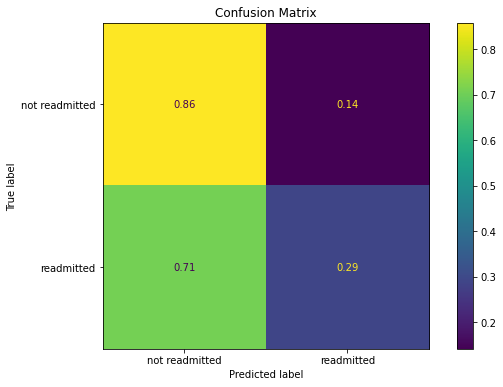

In [29]:
forest = RandomForestClassifier(n_estimators=50, criterion=grid_tree.best_params_['criterion'],
                                max_depth=grid_tree.best_params_['max_depth'],
                                min_samples_split=grid_tree.best_params_['min_samples_split'],
                                min_samples_leaf=grid_tree.best_params_['min_samples_leaf'],
                                random_state=7
                               )
forest_scores = run_model(forest)

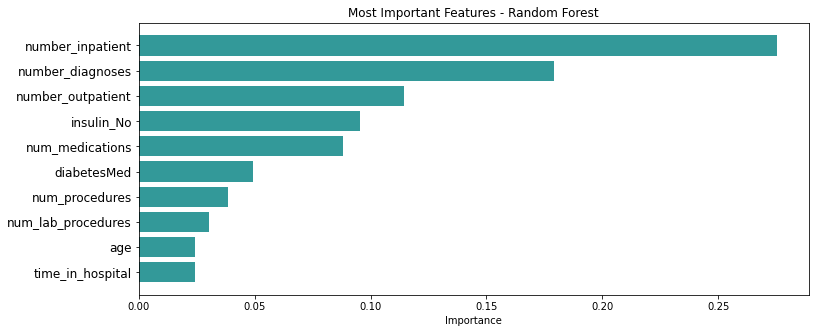

In [30]:
plot_top_10_features(forest, 'Random Forest')

This model has a very poor recall score of .29. Let's see if running a grid search on the random forest can improve our outcomes.

### Random Forest Improved with Grid Search

Let's see if we can improve these results at all by performing a grid search on the random forest.

In [31]:
rf_param_grid = {
    'n_estimators': [100],
    'max_depth': [3,5,10],
    'min_samples_split': [5,10,20],
    'max_features': [5,10,15]
}

In [32]:
rf_grid_search = GridSearchCV(forest, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)

print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Testing Accuracy: 60.33%

Optimal Parameters: {'max_depth': 5, 'max_features': 15, 'min_samples_split': 5, 'n_estimators': 100}


In [33]:
forest_2 = RandomForestClassifier(n_estimators=100,
                                 max_features=rf_grid_search.best_params_['max_features'], 
                                 max_depth=rf_grid_search.best_params_['max_depth'],
                                 min_samples_split=rf_grid_search.best_params_['min_samples_split'],
                                 random_state=9)

                precision    recall  f1-score   support

not readmitted       0.61      0.74      0.67     12972
    readmitted       0.62      0.47      0.54     11541

      accuracy                           0.62     24513
     macro avg       0.62      0.61      0.60     24513
  weighted avg       0.62      0.62      0.61     24513



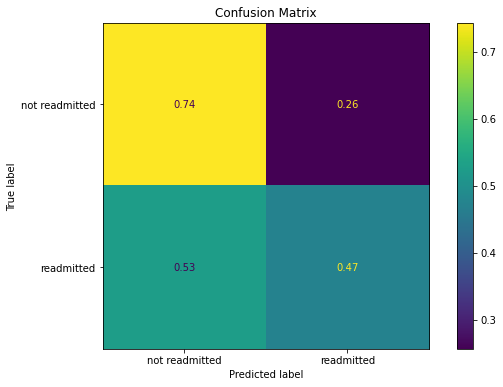

In [34]:
forest_2_scores = run_model(forest_2)

In [35]:
forest_2_scores

{'precision': 0.62, 'recall': 0.47, 'accuracy': 0.62, 'f1': 0.54}

We were able to improve recall to .47.

In [36]:
forest_scores = forest_2_scores

### SMOTE

We haven't handled the class imbalances in our random forest. Let's try the SMOTE methodology of handling class imbalances and see if our results improve.

              precision    recall  f1-score   support

           0       0.62      0.72      0.66     12972
           1       0.61      0.50      0.55     11541

    accuracy                           0.62     24513
   macro avg       0.62      0.61      0.61     24513
weighted avg       0.62      0.62      0.61     24513



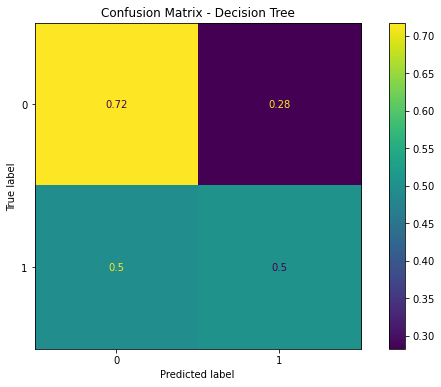

In [37]:
from imblearn.over_sampling import SMOTE

X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train)

# run the model with the resampled training set--have to run outside of the function
smote_model = forest_2.fit(X_train_resampled, y_train_resampled)

y_hat_train = smote_model.predict(X_train_resampled)
y_hat_test = smote_model.predict(X_test)
    
    # print classification report
print(classification_report(y_test, y_hat_test))
    
    # plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrix - Decision Tree')
disp = plot_confusion_matrix(smote_model, X_test, y_test, ax = ax,
                             normalize='true')
plt.grid(False)
    
    
smote_forest_scores = get_scores(y_test, y_hat_test)

In [38]:
smote_forest_scores

{'precision': 0.61, 'recall': 0.5, 'accuracy': 0.62, 'f1': 0.55}

We were able to boost recall to .5 by using SMOTE to handle class imbalances. Let's use this model as our best model for ensemble methods.

In [39]:
forest_scores = smote_forest_scores

## Boosting Methods

Boosting algorithms are also an ensemble of different models. However, instead of each model being trained independently, each model is trained iteratively. Each model is an individual weak learner, which makes them very resistant to overfitting. We are going to try a few different boosting algorithms--Adaboost(Adaptive Boosting), Gradient Boosting and XGBoosting, which is a type of gradient boosting known for very high performance.

### AdaBoost

In [40]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

                precision    recall  f1-score   support

not readmitted       0.62      0.77      0.69     12972
    readmitted       0.65      0.46      0.54     11541

      accuracy                           0.63     24513
     macro avg       0.63      0.62      0.61     24513
  weighted avg       0.63      0.63      0.62     24513



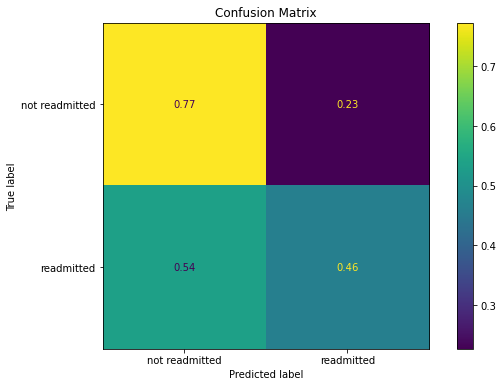

In [41]:
adaboost_clf = AdaBoostClassifier(random_state=42)
ada_scores = run_model(adaboost_clf)

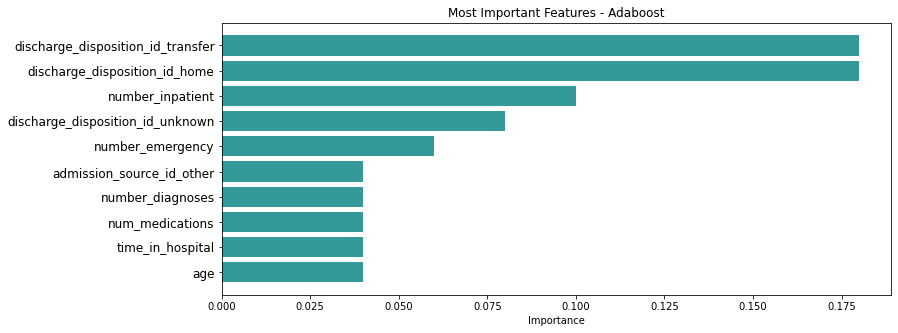

In [42]:
plot_top_10_features(adaboost_clf, 'Adaboost')

In [43]:
ada_scores

{'precision': 0.65, 'recall': 0.46, 'accuracy': 0.63, 'f1': 0.54}

This model has strong precision and accuracy scores, but is not our best scores for recall and f1.

### Gradient Boosting

                precision    recall  f1-score   support

not readmitted       0.62      0.77      0.69     12972
    readmitted       0.65      0.48      0.55     11541

      accuracy                           0.63     24513
     macro avg       0.64      0.62      0.62     24513
  weighted avg       0.64      0.63      0.62     24513



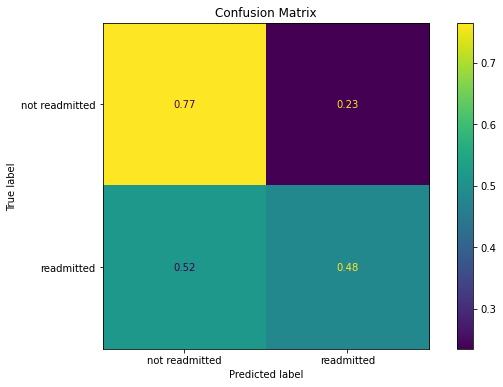

In [44]:
gbt_clf = GradientBoostingClassifier(random_state=42)
gbt_scores = run_model(gbt_clf)

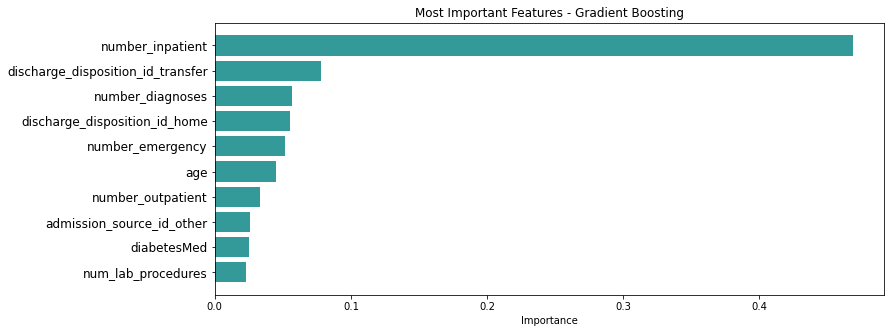

In [45]:
plot_top_10_features(gbt_clf, 'Gradient Boosting')

In [46]:
gbt_scores

{'precision': 0.65, 'recall': 0.48, 'accuracy': 0.63, 'f1': 0.55}

The recall score for our gradient boosting model improved slightly over Adaboost, from .46 to .48.

### XGBoost

In [47]:
from xgboost import XGBClassifier

                precision    recall  f1-score   support

not readmitted       0.64      0.71      0.67     12972
    readmitted       0.63      0.55      0.59     11541

      accuracy                           0.63     24513
     macro avg       0.63      0.63      0.63     24513
  weighted avg       0.63      0.63      0.63     24513



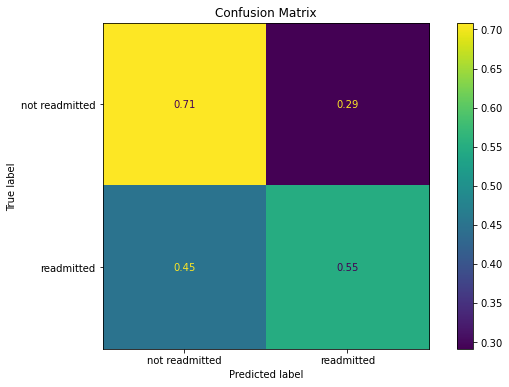

In [48]:
import warnings
warnings.filterwarnings("ignore")

xgb_clf = XGBClassifier(objective ='reg:squarederror', random_state=47)
xgb_scores = run_model(xgb_clf)

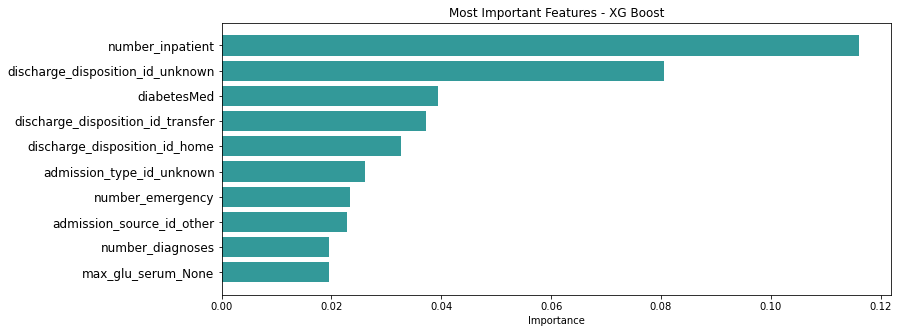

In [49]:
plot_top_10_features(xgb_clf, "XG Boost")

In [50]:
xgb_scores

{'precision': 0.63, 'recall': 0.55, 'accuracy': 0.63, 'f1': 0.59}

We were able to achieve our strongest recall score yet of .55. Let's see if we can improve this score any further using grid search to tune our parameters.

### Improve XGBoost Scores Using GridSearch

In [51]:
xgb_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

In [52]:
warnings.filterwarnings("ignore")

xgb_grid_search = GridSearchCV(xgb_clf, xgb_param_grid, 
                               scoring='recall', cv=None, n_jobs=1, )
xgb_grid_search.fit(X_train, y_train)

print(f"Testing Accuracy: {xgb_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {xgb_grid_search.best_params_}")

Testing Accuracy: 54.23%

Optimal Parameters: {'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.7}


In [53]:
xgb_clf_2 = XGBClassifier(learning_rate = xgb_grid_search.best_params_['learning_rate'],
                          max_depth = xgb_grid_search.best_params_['max_depth'],
                          min_child_weight = xgb_grid_search.best_params_['min_child_weight'],
                          subsample = xgb_grid_search.best_params_['subsample'],
                          n_estimators = xgb_grid_search.best_params_['n_estimators'],
                          objective ='reg:squarederror',
                          random_state=36)

                precision    recall  f1-score   support

not readmitted       0.64      0.72      0.68     12972
    readmitted       0.63      0.55      0.59     11541

      accuracy                           0.64     24513
     macro avg       0.64      0.63      0.63     24513
  weighted avg       0.64      0.64      0.64     24513



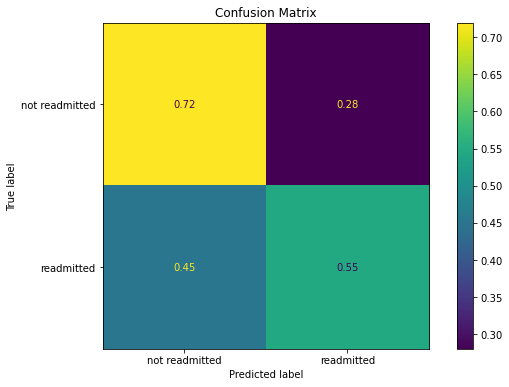

In [54]:
xgb_scores_2 = run_model(xgb_clf_2)

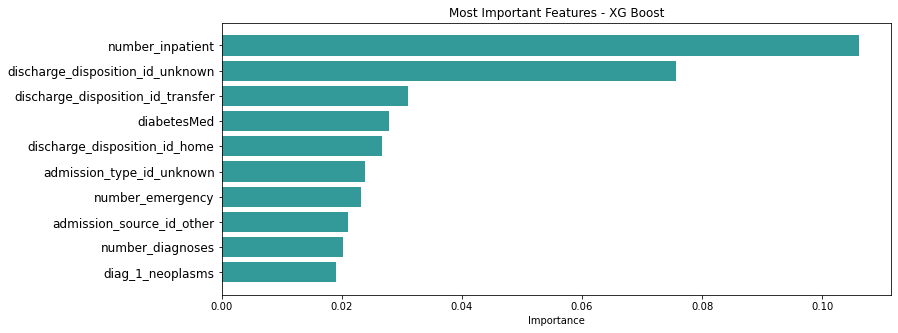

In [55]:
plot_top_10_features(xgb_clf_2, "XG Boost")

In [56]:
xgb_scores_2

{'precision': 0.63, 'recall': 0.55, 'accuracy': 0.64, 'f1': 0.59}

Our accuracy score improved with all other scores held constant. Let's use this model as our final XG Boost model.

In [57]:
xgb_scores = xgb_scores_2

# Interpretation

## Compare scores of different models

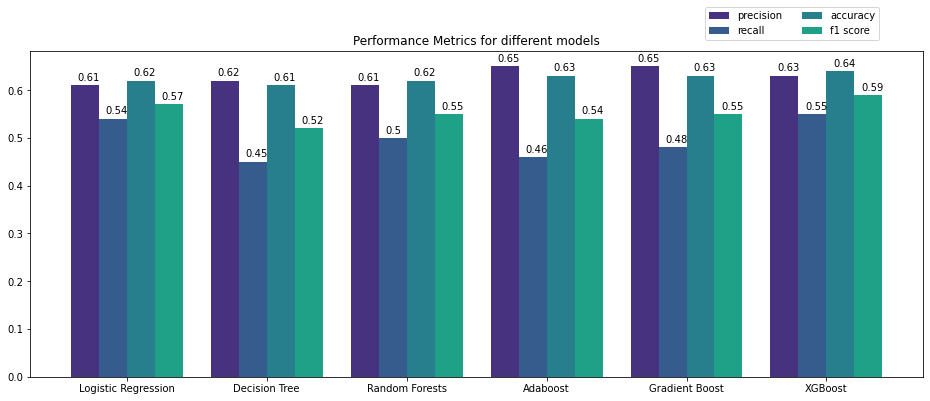

In [58]:
plt.figure(figsize=(16, 6))



ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 
          'Random Forests', 'Adaboost', 'Gradient Boost', 'XGBoost']

values = [log_scores['precision'], tree_scores['precision'], 
          forest_scores['precision'], ada_scores['precision'],
         gbt_scores['precision'], xgb_scores['precision']]

model = np.arange(len(models))

plt.bar(model-.3, values, align='center', width=0.2, label='precision')

plt.xticks(model, models)

ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 
          'Random Forests', 'Adaboost', 'Gradient Boost', 'XGBoost']

values = [log_scores['recall'], tree_scores['recall'], 
          forest_scores['recall'], ada_scores['recall'],
         gbt_scores['recall'], xgb_scores['recall']]

model = np.arange(len(models))

plt.bar(model-.1, values, align='center', width=0.2, label='recall')

plt.xticks(model, models)

ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 
          'Random Forests', 'Adaboost', 'Gradient Boost', 'XGBoost']

values = [log_scores['accuracy'], tree_scores['accuracy'], 
          forest_scores['accuracy'], ada_scores['accuracy'],
         gbt_scores['accuracy'], xgb_scores['accuracy']]

model = np.arange(len(models))

plt.bar(model+.1, values, align='center', width=0.2, label='accuracy')

plt.xticks(model, models)


ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 
          'Random Forests', 'Adaboost', 'Gradient Boost', 'XGBoost']

values = [log_scores['f1'], tree_scores['f1'], 
          forest_scores['f1'], ada_scores['f1'],
         gbt_scores['f1'], xgb_scores['f1']]

model = np.arange(len(models))

plt.bar(model+.3, values, align='center', width=0.2, label='f1 score')

plt.xticks(model, models)

plt.title("Performance Metrics for different models")

ax.legend(loc="upper left", bbox_to_anchor=(.75, 1.15), ncol=2)

for p in ax.patches:
    height = p.get_height() 
    width = p.get_width() 
    ax.text(x = p.get_x() + width/4, 
            y = (height+.01),
            s = height) 

#plt.show();
plt.savefig('images/model_metrics.png')

Based on our final metrics and the fact that recall is our most important metric, we are going to proceed with the XG Boost model, which has the highest recall score of 0.53.

## Interpret Performance of Final Model

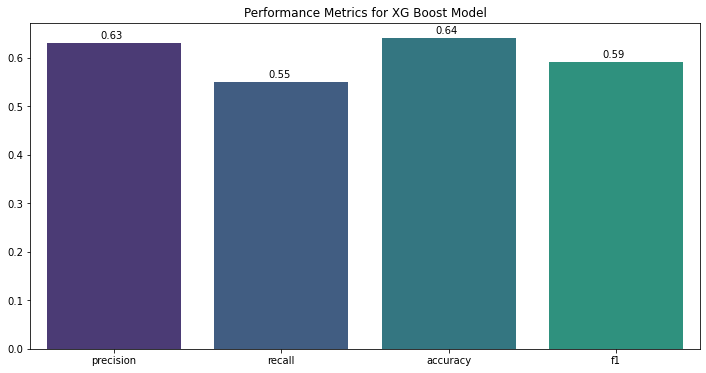

In [59]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=list(xgb_scores.keys()), y=list(xgb_scores.values()))
plt.title("Performance Metrics for XG Boost Model")

for p in ax.patches:
    height = p.get_height() 
    width = p.get_width() 
    ax.text(x = p.get_x() + width/2.5, 
            y = (height+.01),
            s = height) 

plt.savefig('images/xgboost_metrics.png')

**Precision**: A precision value of 0.63 means that for every time the model predicted that someone would be readmitted, 63% of the time the patient was actually readmitted (true positives/predicted positives).

**Recall**: Recall was the evaluation metric we were most concerned about. A recall value of .55 means that out of all the patients that were actually readmitted, the model correctly predicted 55% of them would be readmitted. Although a value of .55 needs some improvement, this model obtained better recall scores than all other models used.

**Accuracy**: An accuracy value of 0.63 means that out of all the predictions our model made, 64% of them were correct. Although this is a holistic view of model performance, we aren't as interested in it, since we aren't as interested in predicting non-readmissions.

**F1 Score**: The F1 score is the harmonic mean between precision and recall, and penalizes a model if it skews toward recall or precision. This model achieved an F1 score of 59%.

## Interpret Results of Final Model

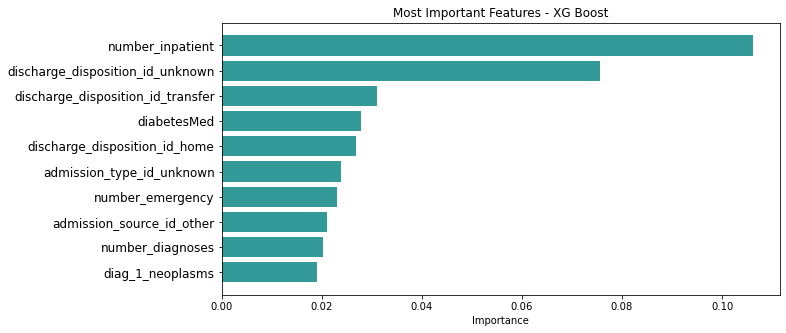

In [60]:
# run full code instead of plot features function to use savefig
feature_names = X_train.columns
feature_imports = xgb_clf_2.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], 
                                 columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)

plt.figure(figsize=(10,5))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, 
         align='center', alpha=0.8, color='teal')
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=12)
plt.xlabel('Importance')
plt.title(f'Most Important Features - XG Boost', fontsize=12)
plt.savefig('images/feature_importance.png')

Some of the top most important features of our model are:
* number of inpatient visits
* type of discharge--unknown, transfer or home
* whether the patient is on diabetes medications
* number of diagnoses
* diagnosis of neoplasms

Let's explore some of these features and their relationship with 'Readmitted'.

### Inpatient Visits vs. Readmits

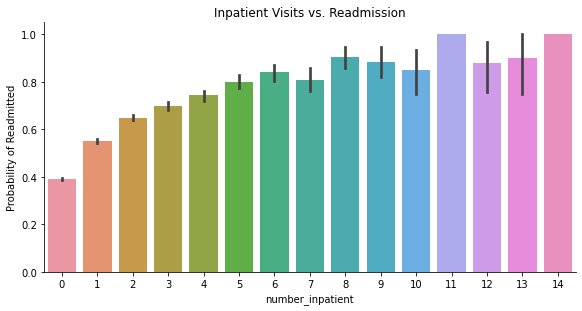

In [61]:
x_label = 'Inpatient Visits'
ax = sns.catplot(x = "number_inpatient", y="readmitted", 
            data = data[data['number_inpatient']<15], height=4, aspect=2, kind ="bar")
ax.set_ylabels("Probability of Readmitted")
plt.title(f'{x_label} vs. Readmission')
plt.show();

As a general trend, as the amount of inpatient visits a patient has had in the last year increases, the more likely it is that the patient will be readmitted. This makes sense, since a patient that has already been a patient in the hospital many times is likely either very sick or is not receiving the proper treatment, hence all of the hospital visits. These patients may have chronic conditions that need to be managed, and the hospital may not be able to help this patient. The hospital should pay special attention to patients that have been in inpatient care more than 5 times a year, but more insight would need to be gained on each individual patient before providing further recommendations.

### Diagnoses vs. Readmits

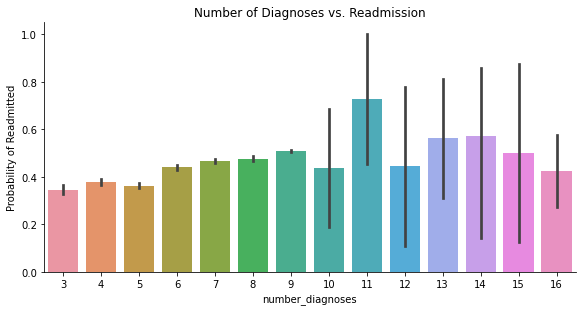

In [62]:
x_label = 'Number of Diagnoses'

ax = sns.catplot(x = "number_diagnoses", y="readmitted", 
            data = data, height = 4, kind = "bar", aspect=2)
ax.set_ylabels("Probability of Readmitted")
plt.title(f'{x_label} vs. Readmission');
plt.show();

It appears there is a relationship between the number of diagnoses of a patient and the probability of being readmitted. Since there's more noise in the data when we get past 10 diagnoses, let's take a closer look at the relationship with fewer than 10 diagnoses.

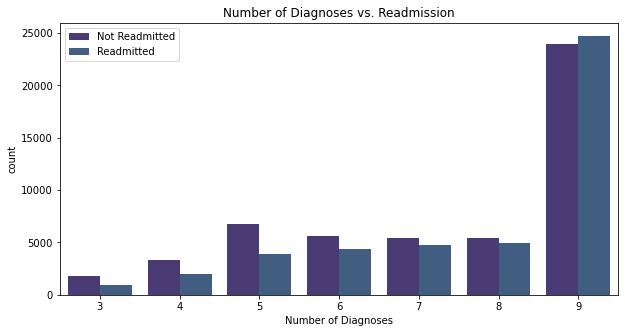

In [63]:
x_label = 'Number of Diagnoses'

fig = plt.figure(figsize=(10,5))
ax = sns.countplot(x = 'number_diagnoses', 
                   data = data[data['number_diagnoses']<10], hue='readmitted')
ax.set(xlabel=x_label)

legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Not Readmitted','Readmitted'])
plt.title(f'{x_label} vs. Readmission');

It does appear that as the number of diagnoses increases, the more likely it is that the patient will be readmitted, at least for when number of diagnoses is less than 10.

We also found that having a primary diagnosis of neoplasms is a significant feature in predicting readmission.

### Neoplasm Diagnoses vs. Readmits

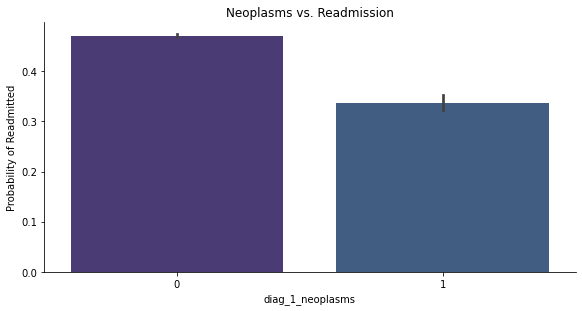

In [64]:
x_label = 'Neoplasms'

ax = sns.catplot(x = "diag_1_neoplasms", y="readmitted", 
            data = data, height = 4, aspect=2, kind ="bar")
ax.set_ylabels("Probability of Readmitted")
plt.title(f'{x_label} vs. Readmission')
plt.show();

Patients with neoplasms as their primary diagnosis are less likely to be readmitted--therefore, hospitals can focus more on patients with other primary diagnoses.

### Discharge type vs. Readmits

Three different types of discharges--unknown, home and transfer, were considered important features in predicting readmissions. Let's take a closer look at the relationship with these discharge types.

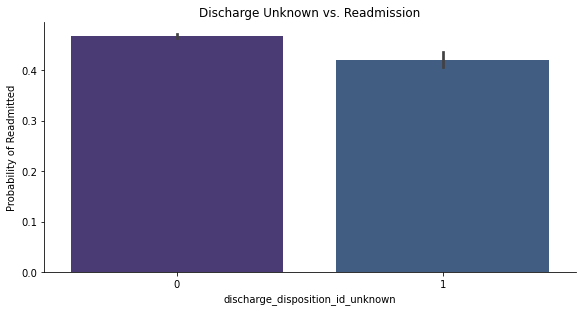

In [65]:
x_label = 'Discharge Unknown'
ax = sns.catplot(x = "discharge_disposition_id_unknown", y="readmitted", 
            data = data, height = 4, aspect=2, kind ="bar")
ax.set_ylabels("Probability of Readmitted")
plt.title(f'{x_label} vs. Readmission')
plt.show();

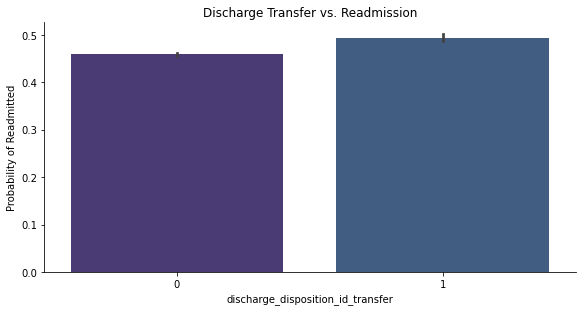

In [66]:
x_label = 'Discharge Transfer'
ax = sns.catplot(x = "discharge_disposition_id_transfer", y="readmitted", 
            data = data, height = 4, aspect=2, kind ="bar")
ax.set_ylabels("Probability of Readmitted")
plt.title(f'{x_label} vs. Readmission')
plt.show();

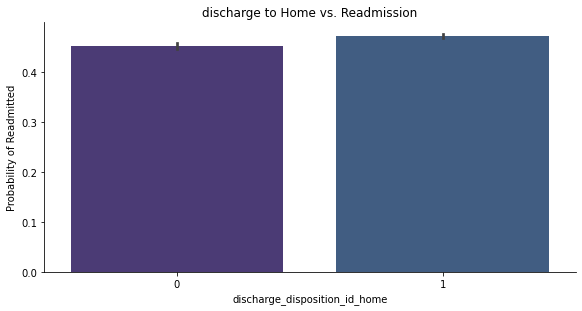

In [67]:
x_label = 'discharge to Home'
ax = sns.catplot(x = "discharge_disposition_id_home", y="readmitted", 
            data = data, height = 4, aspect=2, kind ="bar")
ax.set_ylabels("Probability of Readmitted")
plt.title(f'{x_label} vs. Readmission')
plt.show();

It appears that patients being transferred or discharged home are more likely to be readmitted rather that not, while patients with unknown discharge types are more likely not to be readmitted. Since discharging a patient to home is something that can be most easily controlled by the hospital, we will focus on this variable in our recommendations.

### Diabetes Medication vs. Readmits

There is also a significant relationship between readmissions and whether or not the patient is on diabetes medication.

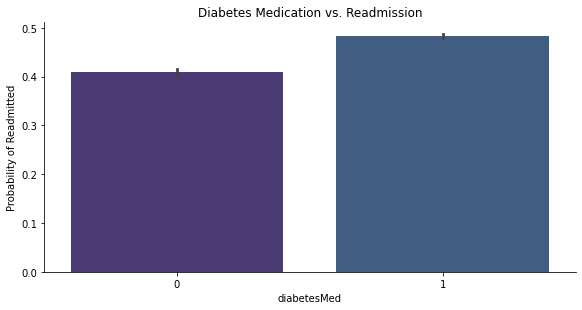

In [68]:
x_label = 'Diabetes Medication'
ax = sns.catplot(x = "diabetesMed", y="readmitted", 
            data = data, height = 4, aspect=2, kind ="bar")
ax.set_ylabels("Probability of Readmitted")
plt.title(f'{x_label} vs. Readmission')
plt.show();

Patients that are on diabetes medications are more likely to readmitted compared to patients not on diabetes medications.

## Recommendations

**1. Be careful with patients being discharged to home.** Patients that are discharged to a home setting have the highest likelihood of being readmitted. Before discharging a patient to home, the hospital staff should be extra cautious that the patient is stable and its conditions are being properly treated.

**2. Pay attention to patients on diabetes medication.** Patients that are on diabetes medication are more likely to be readmitted than patients not on diabetes medicine. Hospitals could require a higher threshold of improvement and stabilization from these patients before discharge to try to prevent a readmit. 

**3. Spend resources on patients with a high number of diagnoses, but do not focus heavily on patients with a primary diagnosis of  neoplasms.** As the number of diagnoses a patient has increases, the more likely it is that a patient will need to be readmitted, however, patients with neoplasms as their primary diagnosis are much less likely to be readmitted. Although it might seem intuitive that patients with more diagnoses need more care, it may not be that patients with neoplasms are at a lower risk. Hospital staff could focus resources on patients with other illnesses more so than neoplasms, since these patients are much less likely to be readmitted.

## Limitations and Future Work

Although we were able to improve the performance of our model, there is still room for improvement, as our accuracy is only 64% and recall 53%. We would need to do finer tuning of the model before it could be confidently used to predict readmission outcomes.

In the future, we could potentially perform additional cleaning on the data to improve performance. This could include scaling continuous variables or binning our categorical variables in a different way.


It also may be helpful in the future to focus on different groups of patients and perform separate analyses on those groups. For example, we could break the patients into categories by their primary diagnosis and see if there are different important predictors for each of these diagnoses.

With a lot more time and resources, it would be interesting to expand this analysis beyond just diabetes patients. There are medications specific to diabetes patients, which means our model may not be able to be applied to the broader hospital population; however, expanding this analysis would require significant investment in more data collection.
